#### Goal :: Predict the sale (number of items) for the shop-item pair in the  test set. The test set is for one month - November 2015 

In [5]:
from datetime import datetime, timedelta, date
from calendar import monthrange
from pytz import timezone
import pandas as pd
import numpy as np
import feather
import datetime 
import pytz
import csv
import os
import seaborn as sns
import matplotlib.pyplot as plt
import logging

%matplotlib inline

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def get_dates_in_month(year, month, time_zone):
    num_days = monthrange(year, month)[1]
    first_date_of_month = datetime.datetime(year,month,1, tzinfo=time_zone)
    last_date_of_month =  datetime.datetime(year,month,num_days, tzinfo=time_zone)
    return get_dates_inrange(first_date_of_month, last_date_of_month)


def get_dates_inrange(date1, date2):
    if (not isinstance(date1, datetime.datetime)) | (not isinstance(date2, datetime.datetime)):
        return "date1 and date2 should be of type datetime.date"
    num_days = (date2 - date1).days + 1
    date_list = [date1 + datetime.timedelta(days=x) for x in range(0, num_days)]
    return date_list

In [6]:
DATA_FOLDER = './data/'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
date_df = pd.read_pickle(os.path.join(DATA_FOLDER, "russian_holidays.pkl"))
geography = pd.read_csv(os.path.join(DATA_FOLDER, 'geography.csv'))
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz')) 
holidays = feather.read_dataframe(os.path.join(DATA_FOLDER, 'hol.feather'))

In [8]:
print("training data (sales) -> " + str(sales.shape))
print("test data -> " + str(test.shape))
print("\n")
print("Total Items: {}".format(items.item_id.nunique()))
print("Total Categories: {}".format(item_categories.item_category_id.nunique()))
print("Total Shops: {}".format(shops.shop_id.nunique()))
print("\n--------------------------------------------------------\n")

print("Training data")
print("  # unique shops: {}".format(sales.shop_id.nunique()))
print("  # unique items: {}".format(sales.item_id.nunique()))

print("\n--------------------------------------------------------\n")
print("Test data")
print("  # unique shops: {}".format(test.shop_id.nunique()))
print("  # unique items: {}".format(test.item_id.nunique()))


%matplotlib inline
transactions = sales
# Drop the rows with price lt zero. ther is only one.
transactions = transactions[transactions.item_price > 0]

# Merging to get category_id in the transaction df
transactions = pd.merge(transactions, items[['item_id', 'item_category_id']], on='item_id', how='left')

print("\n\n")

items_test_nottrans = len(set(test.item_id.unique()) - set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
intersection_items_test_transac = len(set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
item_count_test = len(set(test.item_id.unique()))

print("# items in test set: {}".format(item_count_test))
print("# items in test set and transaction set: {}".format(intersection_items_test_transac))
print("# items in test but not transaction: {}".format(items_test_nottrans))

print("\n")

shops_test_nottrans = len(set(test.shop_id.unique()) - set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
intersection_shops_test_transac = len(set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
shop_count_test = len(set(test.shop_id.unique()))

print("# shops in test set: {}".format(shop_count_test))
print("# shops in test set and transaction set: {}".format(intersection_shops_test_transac))
print("# shops in test but not transaction: {}".format(shops_test_nottrans))

print("\n")
 
test.head()

training data (sales) -> (2935849, 6)
test data -> (214200, 3)


Total Items: 22170
Total Categories: 84
Total Shops: 60

--------------------------------------------------------

Training data
  # unique shops: 60
  # unique items: 21807

--------------------------------------------------------

Test data
  # unique shops: 42
  # unique items: 5100



# items in test set: 5100
# items in test set and transaction set: 4737
# items in test but not transaction: 363


# shops in test set: 42
# shops in test set and transaction set: 42
# shops in test but not transaction: 0




,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [146]:
print(len(test.item_id.unique()))

len( set(test.item_id.unique()).intersection(set(items.item_id.unique())))

5100


5100

##### Building the shops data frame

In [9]:
# Setting the shop_type
shops_df = shops

shop_types = ['ТЦ', 'ТРК', 'ТРЦ', 'МТРЦ', 'ТК', 'online']
shops_df["shop_type"] = shops_df.shop_name.apply(lambda x: x.split()[1] if x.split()[1] in shop_types else 'OTH')
shops_df.loc[shops_df.shop_id.isin([12, 55]) , 'shop_type'] = "online"
shops_df.loc[shops_df.shop_id == 9 , 'shop_type'] = "outbound"

# Setting the city for each shop
shops_df["city"] = shops_df.shop_name.apply(lambda x: x.split()[0].replace("!", ""))
shops_df.loc[shops_df.city.isin(["Интернет-магазин", "Цифровой", "Выездная"]) , 'city'] = "no_city"

 # Appending the geographic info to shops df
shops_df = pd.merge(shops_df, geography.drop(['city_eng'], axis=1), on='city', how='left')


# Get rid of NaN values from 'time_wrt_utc' and 'dist_from_moscow' columns
# for c in ['time_wrt_utc', 'dist_from_moscow']:
#     shops_df.loc[shops_df[c].isnull(), c] = np.mean(shops_df[c])

# Changing the type to 'category'
catg = ['shop_type', 'city', 'fed_subject', 'fed_dist']
for c in catg:
    shops_df[c] = shops_df[c].astype('category')

print(shops_df.shape)
shops_df.head()

(60, 8)


,shop_name,shop_id,shop_type,city,time_wrt_utc,fed_subject,fed_dist,dist_from_moscow
0,"!Якутск Орджоникидзе, 56 фран",0,OTH,Якутск,9.0,Sakha Republic,Far East,8395.0
1,"!Якутск ТЦ ""Центральный"" фран",1,ТЦ,Якутск,9.0,Sakha Republic,Far East,8395.0
2,"Адыгея ТЦ ""Мега""",2,ТЦ,Адыгея,3.0,Adygea Republic,South,1589.0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,ТРК,Балашиха,3.0,Moscow Oblast,Central,26.0
4,"Волжский ТЦ ""Волга Молл""",4,ТЦ,Волжский,3.0,Volgograd Oblast,South,993.0


### These are entries for Online - 'shops'

Выездная Торговля	9	OTH	Выездная	-1	NaN	NaN	-1          (exit trade)

Интернет-магазин ЧС	12	OTH	Интернет-магазин	-1	NaN	NaN	-1   (Online shop Emergency)

Цифровой склад 1С-Онлайн	55	OTH	Цифровой	-1	NaN	NaN	-1 (Digital warehouse 1C-Online)

#### Building a date df, and block_num_info df for adding temporal data.

In [10]:
# setting up the calendar and the Block_num info dataframe

moscow = timezone('Europe/Moscow')
train_first_date = datetime.datetime(2013,1,1, tzinfo=moscow)
train_last_date =  datetime.datetime(2015,11,30, tzinfo=moscow)

date_df = pd.DataFrame(get_dates_inrange(train_first_date, train_last_date), columns=['date'])

date_df['weekday'] = date_df['date'].apply(lambda x: x.isoweekday())
date_df['is_weekend'] = date_df['weekday'] > 5

# Holidays dataframe - (preparing df)
holidays_b = holidays
holidays_b['date_str'] = holidays_b.date.apply(lambda x: x.isoformat().split("T")[0])
holidays_b['off_day'] =  holidays_b.h_type.apply(lambda x: x.split(",")[0] == 'National holiday')
holidays_b['is_holiday'] = True

date_df['date_str'] = date_df.date.apply(lambda x: x.isoformat().split("T")[0])

date_df = pd.merge(date_df, holidays_b[['date_str', 'is_holiday']], on='date_str', how='left')
date_df['is_holiday'].fillna(False, inplace=True)

date_df = pd.merge(date_df, holidays_b[['off_day', 'date_str']], on='date_str', how='left')
date_df.loc[date_df.loc[:, 'weekday'] > 5, 'off_day'] = True


def add_date_block_num(d):
    if(d.year == 2013):
        base=0
    elif(d.year == 2014):
        base=12
    elif(d.year == 2015): 
        base=24
    return base + (d.month-1)

date_df['date_block_num'] = date_df['date'].apply(lambda x: add_date_block_num(x))

date_df.head()


# Block info df
block_num_info = date_df[date_df.is_weekend == True].groupby('date_block_num')['is_weekend'].sum().reset_index(name = "weekends")

block_num_info['holidays'] = date_df[date_df.is_holiday == True].groupby('date_block_num')['is_holiday'].sum()
block_num_info['holidays'].fillna(0, inplace=True)

block_num_info['off_days'] = date_df[date_df.off_day == True].groupby('date_block_num')['off_day'].sum()
block_num_info['off_days'].fillna(0, inplace=True)

block_num_info.head()

,date_block_num,weekends,holidays,off_days
0,0,8.0,7.0,14
1,1,8.0,2.0,8
2,2,10.0,2.0,11
3,3,8.0,0.0,8
4,4,8.0,9.0,16


#### Build the initial training df

In [11]:
from datetime import datetime, date, time

# 'sales' is the input training dataframe
#sales['date'] = pd.to_datetime(sales['date'])

sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


<Figure size 432x288 with 0 Axes>

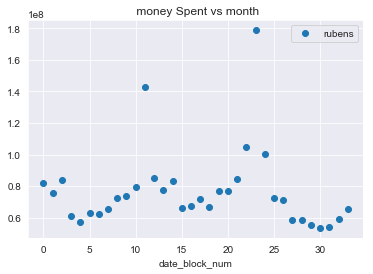

In [12]:
# Money spent every month ( We see the seasonality!)
plt.clf()
total_transactions_monthly = sales[sales['item_cnt_day'] > 0].groupby('date_block_num')['item_price'].sum().reset_index(name = "rubens")
sns.set_style("darkgrid")
total_transactions_monthly.plot(x='date_block_num', y='rubens', style='o')
plt.title(" money Spent vs month")
plt.show()

In [13]:
# remove date column
sales_monthly = sales #.drop(['date'], axis=1)

# Aggregating item_cnt_day (summing) and item_price(averaging)
agg_funcs = {'item_cnt_day':np.sum, 'item_price':np.mean}
sales_monthly = sales_monthly.groupby(['date_block_num', 'shop_id', 'item_id']).agg(agg_funcs).reset_index()

# rename the columns
sales_monthly.rename(columns={'item_price':'item_avg_price', 'item_cnt_day':'item_cnt_month'}, inplace=True)

# Adding month numbers (jan1, feb-2, march-3....dec-12)
sales_monthly['month'] = (sales_monthly['date_block_num'] % 12)+1



# Appending

# shop information
sales_monthly = pd.merge(sales_monthly, shops_df, on='shop_id', how='left')

# block_num_info (temporal features)
sales_monthly = pd.merge(sales_monthly, block_num_info, on='date_block_num', how='left')

# item info
sales_monthly = pd.merge(sales_monthly, items, on='item_id', how='left')

print(sales_monthly.shape)

sales_monthly.head()

(1609124, 18)


,date_block_num,shop_id,item_id,item_cnt_month,item_avg_price,month,shop_name,shop_type,city,time_wrt_utc,fed_subject,fed_dist,dist_from_moscow,weekends,holidays,off_days,item_name,item_category_id
0,0,0,32,6.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14,1+1,40
1,0,0,33,3.0,347.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14,1+1 (BD),37
2,0,0,35,1.0,247.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14,10 ЛЕТ СПУСТЯ,40
3,0,0,43,1.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14,100 МИЛЛИОНОВ ЕВРО,40
4,0,0,51,2.0,128.5,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14,100 лучших произведений классики (mp3-CD) (Dig...,57


<Figure size 432x288 with 0 Axes>

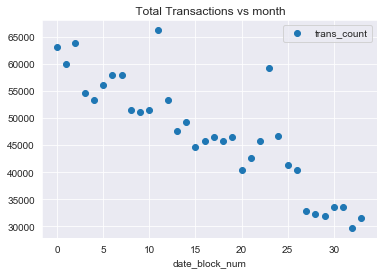

<Figure size 432x288 with 0 Axes>

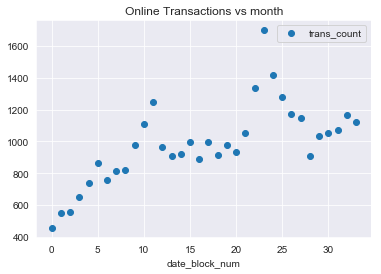

<Figure size 432x288 with 0 Axes>

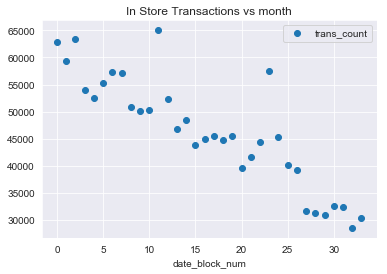

In [14]:
# Online vs In-store sales

phy_stores_list = list(set(shops_df.shop_id) ^ set([12,55]))

plt.clf()
total_transactions_monthly = sales_monthly.groupby('date_block_num').size().reset_index(name = "trans_count")
sns.set_style("darkgrid")
total_transactions_monthly.plot(x='date_block_num', y='trans_count', style='o')
plt.title(" Total Transactions vs month")
plt.show()

plt.clf()
online_transactions_monthly = sales_monthly[sales_monthly['shop_id'].isin([12,55])].groupby('date_block_num').size().reset_index(name = "trans_count")
sns.set_style("darkgrid")
online_transactions_monthly.plot(x='date_block_num', y='trans_count', style='o')
plt.title("Online Transactions vs month")
plt.show()

plt.clf()
instore_transactions_monthly = sales_monthly[sales_monthly['shop_id'].isin(phy_stores_list)].groupby('date_block_num').size().reset_index(name = "trans_count")
sns.set_style("darkgrid")
instore_transactions_monthly.plot(x='date_block_num', y='trans_count', style='o')
plt.title("In Store Transactions vs month")
plt.show()

### Observation:
1. In-store transactions are decreasing every month !!

2. Online sales are increasing !!

3. The total transactions are decreasing every month.... this is surprising !!

<Figure size 432x288 with 0 Axes>

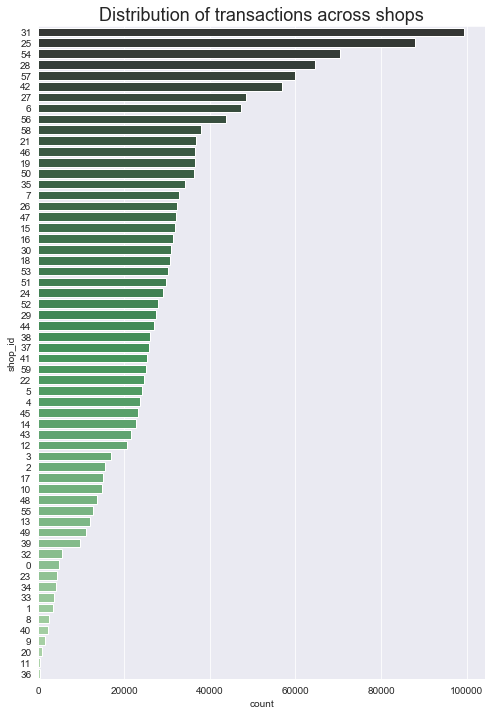

In [15]:
plt.clf()

# Plot the shopi-transactions
sns.set_color_codes("muted")
f, ax = plt.subplots(figsize=(8, 12))
sns.set(font_scale=1.5)

sns.countplot(y="shop_id", data=sales_monthly, palette="Greens_d", order = sales_monthly['shop_id'].value_counts().index)

plt.title("Distribution of transactions across shops")
plt.show()


In [191]:
# sales_monthly.groupby("shop_id")['item_id'].nunique()

# test.groupby("shop_id").size().reset_index(name = "trans_count_for_the_shop")


<Figure size 432x288 with 0 Axes>

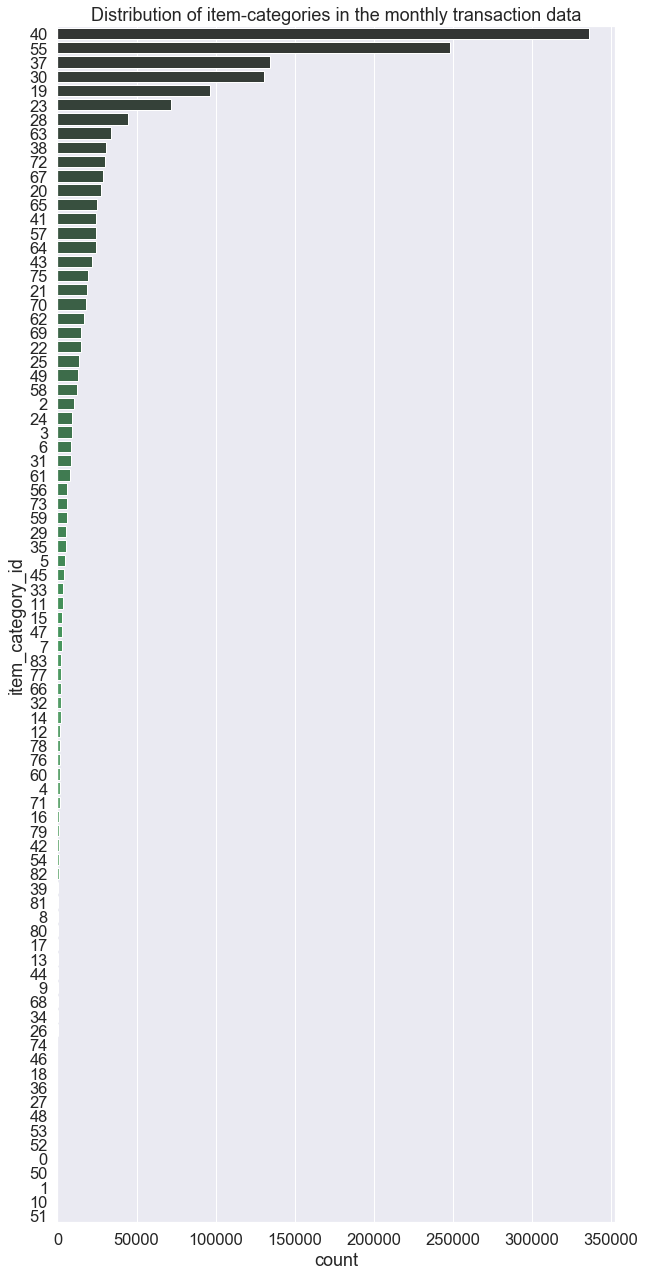

In [16]:
plt.clf()

# Plot the shopid-transactions
sns.set_color_codes("muted")
f, ax = plt.subplots(figsize=(10, 22))
sns.set(font_scale=1.5)

sns.countplot(y="item_category_id", data=sales_monthly, palette="Greens_d",
              order = sales_monthly['item_category_id'].value_counts().index)

plt.title("Distribution of item-categories in the monthly transaction data")
plt.show()


In [18]:
# item_catgs = [51, 10, 1, 50, 0, 52, 53, 48, 27, 36, 18, 46, 74, 26, 34, 68, 9, 44, 13,
#               17, 80, 8, 81, 39, 82, 54, 42, 79, 16, 71, 4, 60, 76, 78]
# plt.clf()

# # Plot the shopi-transactions
# sns.set_color_codes("muted")
# f, ax = plt.subplots(figsize=(10, 22))
# sns.set(font_scale=1.5)
# df = sales_monthly[sales_monthly['item_category_id'].isin(item_catgs)]

# sns.countplot(y="item_category_id", data=sales_monthly[sales_monthly['item_category_id'].isin(item_catgs)],
#               palette="Greens_d", order = df['item_category_id'].value_counts().index)
# plt.title("Distribution of Item categories( with count < 1650) in monthly transaction data")
# plt.show()

In [6]:
# items.head(100)

In [5]:
# item_categories

## Model Training

In [19]:
from sklearn.cross_validation import ShuffleSplit, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')


C:\Users\purne\Miniconda3\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\purne\Miniconda3\envs\py36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [20]:
sales_monthly.columns.tolist()

print(len(sales_monthly.columns.tolist()))

18


In [22]:
# Feature  List  

numeric_var = list([  "dist_from_moscow", "holidays", "off_days"])
categ_var = list(['shop_id' , 'shop_type', 'time_wrt_utc',  "weekends", 'city', 'fed_subject', 'fed_dist', 'item_category_id', 'item_id'])
text_var  = list(['item_name', 'shop_name'])
temporal_var = list(['date_block_num', 'month' ])
target_var = 'item_cnt_month'

sales_monthly[categ_var] = sales_monthly[categ_var].apply(lambda x: x.astype('category'))
sales_monthly[numeric_var] = sales_monthly[numeric_var].apply(lambda x: pd.to_numeric(x, downcast='float'))
sales_monthly[text_var] = sales_monthly[text_var].apply(lambda x: x.astype('str'))
sales_monthly[temporal_var] = sales_monthly[temporal_var].apply(lambda x: x.astype('int'))

sales_monthly.head(4)

,date_block_num,shop_id,item_id,item_cnt_month,item_avg_price,month,shop_name,shop_type,city,time_wrt_utc,fed_subject,fed_dist,dist_from_moscow,weekends,holidays,off_days,item_name,item_category_id
0,0,0,32,6.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14.0,1+1,40
1,0,0,33,3.0,347.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14.0,1+1 (BD),37
2,0,0,35,1.0,247.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14.0,10 ЛЕТ СПУСТЯ,40
3,0,0,43,1.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14.0,100 МИЛЛИОНОВ ЕВРО,40


In [23]:
import nltk

from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec

# Input to Word2Vec is ->
# [['at', 't', 'worldwid', 'prepaid', 'phone', 'card'],
#  ['pk', 'religi', 'cand', 'milagro', 'de', 'tepeyac'],
#  ['jenna', 'bra', 'yelw', 'dsv', 'onli'],
#  ['davinci', 'jenni', 'lind', 'stationari', 'crib', 'eboni'],
#  ['slice', 'toaster', 'white', 'pk']] - > Array(Array(String))

import re

def remove_nonAlphaNumeric(s: str):
    return re.sub(r'\W+', '', s)

def tokenize_item_names(raw_text: str):
    lower_tokens = [w.lower() for w in word_tokenize(raw_text)]
    refined_tokens = [remove_nonAlphaNumeric(w) for w in lower_tokens]
    return list(filter(None, refined_tokens))

2018-11-21 01:38:37,135 : INFO : 'pattern' package not found; tag filters are not available for English


In [24]:
items = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
items['tokenized_item_names'] = items['item_name'].apply(tokenize_item_names)

In [25]:
items.head()

,item_name,item_id,item_category_id,tokenized_item_names
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,"[во, власти, наваждения, пласт, d]"
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,"[abbyy, finereader, 12, professional, edition,..."
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,"[в, лучах, славы, unv, d]"
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,"[голубая, волна, univ, d]"
4,***КОРОБКА (СТЕКЛО) D,4,40,"[коробка, стекло, d]"


In [26]:
tokenized_item_names = list(items['tokenized_item_names'])  

In [27]:
model = Word2Vec(
    tokenized_item_names,
    size = 100,
    window = 5,
    min_count = 3,
    workers = 6)

model.train(tokenized_item_names, total_examples = len(tokenized_item_names), epochs=30)
model.save("./word2vec/word2vec.model")
model.wv.save("./word2vec/custom_w2v.wv")

2018-11-21 01:48:27,803 : INFO : collecting all words and their counts
2018-11-21 01:48:27,805 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-11-21 01:48:27,834 : INFO : PROGRESS: at sentence #10000, processed 69241 words, keeping 10258 word types
2018-11-21 01:48:27,861 : INFO : PROGRESS: at sentence #20000, processed 120597 words, keeping 17750 word types
2018-11-21 01:48:27,869 : INFO : collected 19154 word types from a corpus of 133510 raw words and 22170 sentences
2018-11-21 01:48:27,870 : INFO : Loading a fresh vocabulary
2018-11-21 01:48:27,899 : INFO : min_count=3 retains 6583 unique words (34% of original 19154, drops 12571)
2018-11-21 01:48:27,900 : INFO : min_count=3 leaves 117829 word corpus (88% of original 133510, drops 15681)
2018-11-21 01:48:27,937 : INFO : deleting the raw counts dictionary of 19154 items
2018-11-21 01:48:27,939 : INFO : sample=0.001 downsamples 43 most-common words
2018-11-21 01:48:27,940 : INFO : downsampling leaves e

2018-11-21 01:48:29,520 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-11-21 01:48:29,525 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-11-21 01:48:29,526 : INFO : EPOCH - 5 : training on 133510 raw words (98371 effective words) took 0.1s, 774346 effective words/s
2018-11-21 01:48:29,648 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-11-21 01:48:29,650 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-11-21 01:48:29,654 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-11-21 01:48:29,657 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-11-21 01:48:29,659 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-11-21 01:48:29,668 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-11-21 01:48:29,669 : INFO : EPOCH - 6 : training on 133510 raw words (98399 effective words) took 0.1s, 763596 effective words/s
2018

2018-11-21 01:48:31,179 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-11-21 01:48:31,180 : INFO : EPOCH - 17 : training on 133510 raw words (98678 effective words) took 0.1s, 825691 effective words/s
2018-11-21 01:48:31,289 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-11-21 01:48:31,300 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-11-21 01:48:31,305 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-11-21 01:48:31,306 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-11-21 01:48:31,311 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-11-21 01:48:31,314 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-11-21 01:48:31,315 : INFO : EPOCH - 18 : training on 133510 raw words (98414 effective words) took 0.1s, 830007 effective words/s
2018-11-21 01:48:31,422 : INFO : worker thread finished; awaiting finish of 5 more threads
20

2018-11-21 01:48:32,799 : INFO : EPOCH - 29 : training on 133510 raw words (98406 effective words) took 0.1s, 805973 effective words/s
2018-11-21 01:48:32,900 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-11-21 01:48:32,922 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-11-21 01:48:32,926 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-11-21 01:48:32,931 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-11-21 01:48:32,933 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-11-21 01:48:32,936 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-11-21 01:48:32,937 : INFO : EPOCH - 30 : training on 133510 raw words (98444 effective words) took 0.1s, 794967 effective words/s
2018-11-21 01:48:32,938 : INFO : training on a 4005300 raw words (2953998 effective words) took 4.1s, 718450 effective words/s
2018-11-21 01:48:32,939 : INFO : saving Word2Vec object u

In [93]:
mod = Word2Vec.load("word2vec.model")

2018-09-14 00:53:15,708 : INFO : loading Word2Vec object from word2vec.model
2018-09-14 00:53:15,824 : INFO : loading wv recursively from word2vec.model.wv.* with mmap=None
2018-09-14 00:53:15,825 : INFO : setting ignored attribute vectors_norm to None
2018-09-14 00:53:15,826 : INFO : loading vocabulary recursively from word2vec.model.vocabulary.* with mmap=None
2018-09-14 00:53:15,827 : INFO : loading trainables recursively from word2vec.model.trainables.* with mmap=None
2018-09-14 00:53:15,828 : INFO : setting ignored attribute cum_table to None
2018-09-14 00:53:15,829 : INFO : loaded word2vec.model


In [ ]:
# from gensim.models import KeyedVectors
# wv = KeyedVectors.load("custom_w2v.wv", mmap='r')
# wv['professional']

In [193]:
# 'How have the items been chosen for the test set? '
# There are 5100 items in the test set out of which 4737 appear in the training data. Howeever, 363 are not in the training data.
# Smilar split can appear in the private-test set.


s1 = set(items.item_id.unique()) - set(sales.item_id.unique())

df1 = items[items.item_id.isin(s1)]['item_category_id'].value_counts().rename_axis('catgs').reset_index(name='counts').sort_values(by = ['catgs'])

df2 = items['item_category_id'].value_counts().rename_axis('catgs').reset_index(name='counts').sort_values(by = ['catgs'])

print(df1.shape)

print(df2.shape)




(39, 2)
(84, 2)


In [198]:
df1.merge(df2, on='catgs', how='left').merge(item_categories, left_on='catgs', right_on='item_category_id', how='left')

,catgs,counts_x,counts_y,item_category_name,item_category_id
0,0,1,4,PC - Гарнитуры/Наушники,0
1,3,1,34,Аксессуары - PS4,3
2,7,1,24,Аксессуары - XBOX ONE,7
3,12,3,20,Игровые консоли - PS4,12
4,15,1,37,Игровые консоли - XBOX 360,15
5,16,2,20,Игровые консоли - XBOX ONE,16
6,19,3,628,Игры - PS3,19
7,20,18,175,Игры - PS4,20
8,23,5,501,Игры - XBOX 360,23
9,24,7,123,Игры - XBOX ONE,24


In [204]:
sales_monthly.groupby('date_block_num')['item_id'].nunique()

date_block_num
0     8115
1     8168
2     8302
3     8145
4     8339
5     8478
6     8405
7     8031
8     7876
9     8039
10    8089
11    8474
12    7551
13    7134
14    7142
15    6774
16    6685
17    6681
18    6611
19    6363
20    6071
21    6334
22    6322
23    6605
24    6139
25    6053
26    6082
27    5476
28    5283
29    5216
30    5323
31    5108
32    5085
33    5413
Name: item_id, dtype: int64